<h1>Analyzing Pamantasan ng Lungsod ng Pasig Student Sentiments Towards Professor Performance: A Naive Bayes Approach</h1>

Importing necessary libraries

In [200]:
import re
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gradio as gr
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from collections import Counter

# Download NLTK Data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<h2>DATA LOADING AND DESCRIPTION</h2>

The program starts by reading the data from the "Feedback.xlsx" file and provides an informative summary.

In [201]:
feedbacks = pd.read_excel("Feedback.xlsx")

feedbacks.head()

,Label,Comments
0,0,teacher are punctual but they should also give...
1,1,Good
2,1,Excellent lectures are delivered by teachers a...
3,1,Good
4,1,teachers give us all the information required ...


Summarization of dataset prints out total numbers per label type (-1, 0, 1)

In [202]:
# Summarizes the dataset
print("DATASET")
print("DIMENSION: ", feedbacks.shape)
print()
print("SUMMARY")
print(feedbacks.groupby("Label").size()) 
print()

DATASET
DIMENSION:  (4100, 2)

SUMMARY
Label
-1    1537
 0     643
 1    1920
dtype: int64



<h2>DATA PREPROCESSING</h2>

The data must undergo text cleaning and standardization to remove irrelevant information that doesn't contribute to the sentiment detection of text.

In [203]:
# Preprocessing the text
def preprocess_text(text):

    #Lowercase and Removing special characters
    lowercase_text = text.lower()
    cleaned_text = re.sub(r"[^a-zA-Z0-9\s]", "", lowercase_text) 

    # Tokenization
    tokens = word_tokenize(cleaned_text)
    
    #Removal of stop words

    #Declaring English and Tagalog stop words
    stop_words = set(stopwords.words('english')) | set(["akin","aking","ako","alin","am","amin","aming","ang","ano","anumang","apat","at","atin","ating","ay","bababa","bago","bakit","bawat","bilang","dahil","dalawa","dapat","din","dito","doon","gagawin","gayunman","ginagawa","ginawa","ginawang","gumawa","gusto","habang","hanggang","huwag","iba","ibaba","ibabaw","ibig","ikaw","ilagay","ilalim","ilan","inyong","isa","isang","itaas","ito","iyo","iyon","iyong","ka","kahit","kailangan","kailanman","kami","kanila","kanilang","kanino","kanya","kanyang","kapag","kapwa","karamihan","katiyakan","katulad","kaya","kaysa","ko","kong","kumuha","kung","laban","lahat","lamang","likod","lima","maaari","maaaring","maging","makita","marami","marapat","may","mayroon","mga","minsan","mismo","mula","muli","na","nabanggit","naging","nagkaroon","nais","nakita","namin","napaka","narito","nasaan","ng","ngayon","ni","nila","nilang","nito","niya","niyang","noon","o","pa","paano","pababa","paggawa","pagitan","pagkakaroon","pagkatapos","palabas","pamamagitan","panahon","pangalawa","para","paraan","pareho","pataas","pero","pumunta","pumupunta","sa","saan","sabi","sabihin","sarili","sila","sino","siya","tatlo","tayo","tulad","tungkol","una","walang"])

    tokens = [token for token in tokens if token not in stop_words]

    #Lemmatizing each word
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)


feedbacks["processed_feedback"] = feedbacks["Comments"].apply(preprocess_text)

Creating a Bag-of-Words representation and vectorizing the data and declaring the label and features.

In [204]:
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(feedbacks["processed_feedback"])
label = feedbacks["Label"]

To get an unbiased estimate of the model’s performance, we need to evaluate it on the data we didn’t use for training. The dataset is splitted using a single-split method.

To efficiently train the data, SMOTE is used to oversample the minority classes.

In [205]:
#Using smote to oversample the data
smote = SMOTE(sampling_strategy={1:3000, 0:3000, -1:3000}, random_state=100)
features_res, label_res = smote.fit_resample(features, label)

print("Resampled class distribution:", Counter(label_res))
 
x_train, X_test, y_train, y_test = train_test_split(features_res, label_res, test_size=0.2, random_state=42)

Resampled class distribution: Counter({0: 3000, 1: 3000, -1: 3000})


<h2>MODEL TRAINING AND EVALUATION</h2>

The model is then trained and tested. To evaluate the model performance metrics such as accuracy, precision, recall, and F1 score will be measured.

In [206]:

#model = ComplementNB()
model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

<h3>Accuracy</h3>

In [207]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9250


<h3>Precision and Recall</h3>

Precision and recall usees a confusion matrix to introduce them.

In [208]:
cm = confusion_matrix(y_test, y_pred)

<h4>Visualizing the confusion matrix</h4>

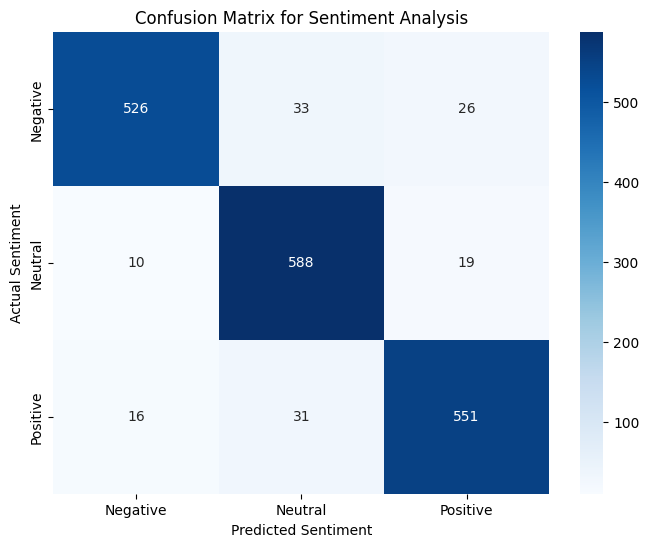

In [209]:
class_labels = {
    -1: "Negative",
    0: "Neutral",
    1: "Positive"
}

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[class_labels[i] for i in class_labels.keys()],
    yticklabels=[class_labels[i] for i in class_labels.keys()],
)

plt.xlabel("Predicted Sentiment")
plt.ylabel("Actual Sentiment")
plt.title("Confusion Matrix for Sentiment Analysis")
plt.show()

In [210]:
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.9260
Recall: 0.9250


<h3>F1 score</h3>

F1 score is the harmonic between precision and recall. 

In [211]:
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"F1 Score: {f1:.4f}")


F1 Score: 0.9250


<h2>PREDICTING SENTIMENT OF NEW FEEDBACK</h2>

Using gradio to simulate the feedback sumbimission process and classifying its sentimental.

In [212]:
def sentiment(text1, text2, text3, text4, text5):
    def classify(text):
        cleaned_comment = preprocess_text(text)
        new_features = vectorizer.transform([cleaned_comment])
        predicted_sentiment = model.predict(new_features)[0]
        
        if predicted_sentiment == 1:
            return "Positive"
        elif predicted_sentiment == 0:
            return "Neutral"
        elif predicted_sentiment == -1:
            return "Negative"

    texts = [text1, text2, text3, text4, text5]
    sentiments = [classify(text) for text in texts]


    outputs = list(zip(texts, sentiments))
    return "\n".join(map(str, outputs))

inputs = [
    gr.Textbox(lines=2, label="1. How would you describe your experience in this class under him/her?", placeholder="Enter feedback here..."),
    gr.Textbox(lines=2, label="2. What are the 3 words that best describe your teacher/instructor?", placeholder="Enter feedback here..."),
    gr.Textbox(lines=2, label="3. What do you think are the areas of improvement of this teacher/instructor in terms of personal competency and personality?", placeholder="Enter feedback here..."),
    gr.Textbox(lines=2, label="4. What do you think are the areas of improvement of this teacher/instructor in terms of professional competence?", placeholder="Enter feedback here..."),
    gr.Textbox(lines=2, label="5. Is there something else you think we should have asked you in this survey? What could it be? Please let us know.", placeholder="Enter feedback here...")
]

outputs = gr.Textbox(lines=10, label="All Sentiments")

app = gr.Interface(
    fn=sentiment,
    inputs=inputs,
    outputs=outputs,
    title="Sentimental Analysis of Student Feedback",
    description="Analyzing Pamantasan ng Lungsod ng Pasig Student Sentiments Towards Professor Performance: A Naive Bayes Approach"
)

app.launch()


Running on local URL:  http://127.0.0.1:7875

To create a public link, set `share=True` in `launch()`.
